# Seq2seq model with Attention mechanism - Machine Translation

### Tutorial Topics
- Seq2seq model with Attention mechanism

### Software Requirements
- Python (>=3.8)
- PyTorch (>=1.13.0)
- Torchtext (>=1.13.0)
- Jupyter (latest)
- NLTK

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Seq2seq model - Quick recap

![](https://drive.google.com/uc?id=1psT_kFqs0LowO5GFkjiAMDB-iOkpbXcT)

Last week, we implemented the seq2seq model which had a encoder that consumes the source sentence (one token at a time) and a decoder that emits the target sentence (one token at a time). 

Although we used LSTM as our underlying encoder and decoder, the encoder/decoder can be a RNN, GRU, LSTM or [Transformer](https://arxiv.org/abs/1706.03762) (which we will learn later in the course). 

In a standard seq2seq model, the hidden state of the decoder at the first timestep is initialized with the hidden state of the encoder at the last timestep (which we referred as **context** vector). Essentially, this context vector can summarize the information present in the source sentence, which is used by the decoder as a reference when it emits a target token.

Note that the figures in this tutorial are adapted from [CS224D](http://web.stanford.edu/class/cs224n/slides/cs224n-2020-lecture08-nmt.pdf).




## Seq2seq model with Attention mechanism

### Problem with traditional seq2seq

![](https://drive.google.com/uc?id=15PsbweisDlhmd9YNoyW4dWfvtAyB--Zl)

The fixed-length **context vector** carries the burden of encoding the complete "meaning" of the input sequence, regardless of its length. This causes the so-called **information bottleneck** problem, which limits the model's ability to deal with longer sequences (and its performance overall). 

Attention provides a solution to this problem.

### Attention mechanism (Informal)
*Core idea of attention:* On each step of the decoder, we use **direct connection to the encoder** to **focus on a particular part** of the source sequence.

We perform a dot product of the current decoder hidden state with each encoder hidden state. And the resulting scores are called as **attention scores**.

![](https://drive.google.com/uc?id=1qQGZKd6k-FwAE86q0W9DTNTD9xpQgt7W)

![](https://drive.google.com/uc?id=1okSgLpyo4yZFbIJ05k86fhjET7mrU3Ng)

These attention scores are unnormalized and hence need to be converted to a probability distribution using softmax to get **attention distribution**.

![](https://drive.google.com/uc?id=1FhS88tXfOGep8gYjg7mK0QYTYRSBH0mw)

In the attention distribution, the attention probabilities corresponding to the source tokens will be high for the tokens that the decoder wants to focus on at any given timestep. In our example, the decoder at the first timestep after consuming the `start` token focuses more on the source token `j'aime` to output the target token `I`.

![](https://drive.google.com/uc?id=19Eu6e-PSPHArsMeuVIwgbYPuTbwsNfU1)

We use the probabilities from the attention distribution to perform a weighted sum of the encoder hidden states. This weighted sum is called as **attention output** or **context vector**. This attention output mostly contains information from the hidden states that received high attention.

![](https://drive.google.com/uc?id=1Aiq9dL9Pom2rJNTwzukIApB6YsPGxJmy)

Then, we concatenate the **attention output** (**context vector**) with the current decoder input embedding, feed it to the RNN and predict the target token (`I` for the first timestep of the decoder).

![](https://drive.google.com/uc?id=1FzcRoBccsDKQfAC4PmWx5gzqXYEImwQ-)

And we repeat these steps (computing attention scores, attention distribution, attention outputs, concatenation with the current decoder input embedding) on each timestep of the decoder.

![](https://drive.google.com/uc?id=1pdtYVb4aHZ6kY310biggab3Ig0oj7Si9)


### Attention mechanism (Formal)

Let us formalize some of the concepts underlying attention mechanism. 

* We have encoder hidden states, $h_1,\dots,h_j,\dots,h_T \in \mathcal{R}^h$
* On timestep $t$, we have decoder hidden state, $s_t \in \mathcal{R}^h$  (where $s_0 = h_T$)
* We have the attention score for a decoder hidden state and an encoder hidden state, $e_{ij} = a(s_{i-1}, h_j) = s_{i-1}^Th_j \in \mathcal{R}$
* We can get the attention score vector for a decoder hidden state, $e_{i} = [e_{i1},\dots,e_{ij},\dots,e_{iT}] \in \mathcal{R}^T$ 
* We take softmax of the attention score vector to get the attention distribution, $\alpha_{i} = softmax(e_{i}) \in \mathcal{R}^T$ 
* We use $\alpha_{i}$ to take a weighted sum of the encoder hidden states to get the attention output or context vector, $c_{i} = \sum_{j=1}^T \alpha_{ij} h_j  \in \mathcal{R}^h$

![](https://drive.google.com/uc?id=1uCfSNcIFazs1s_tFT6j5tfwgo2k5mir4)

### Different ways to compute attention scores

For a given decoder hidden state $s_{i-1}$ and encoder hidden state $h_j$, we compute attention score, $e_{ij} = s_{i-1}^Th_j \in \mathcal{R}$. This way of using dot product to compute attention was introduced by [Luong et al. 2015](https://arxiv.org/abs/1508.04025) and referred in the literature as **Dot-Product/multiplicative** attention. 

However, the first paper which introduced attention mechanism was [Bahdanau et al. 2015](https://arxiv.org/abs/1409.0473). They compute the attention score in the following way, $e_{ij} = v_a tanh (W_a [s_{i-1};h_j;]) \in \mathcal{R}$ where $W_a \in \mathcal{R}^{h\times 2h}$ and $v_a \in \mathcal{R}^{1\times h}$. We will be using **Bahdanau's concatenative/additive attention** in this tutorial. (Note: Bahdanau's is referred to as "concatenative/additive" to distinguish it from Luong's Dot-Product/multiplicative attention. You will see later that, for Bahdanau, we concatenate the attention output (context vector) with the current decoder input embedding).

In this tutorial, we will implement a `Unidirectional` seq2seq model with Bahdanau's attention mechanism for a French to English translation task (the same task we considered in the last week). Hence, you can expect some overlaps of some pieces of today's code with that of last week. :-)

The sections which are taken from the previous tutorial include:
* Preparing Data
* Encoder (1 or few lines different)
* Training the Seq2Seq Model
* Testing Model (1 or few lines different)


### Required libraries

In [2]:
import unicodedata
import string
import re
import random
import time
import datetime
import math
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
import torchtext

import spacy
import numpy as np

### Preparing Data

***Define tokenizers:***
we create the tokenizers. A tokenizer is used to turn a string containing a sentence into a list of individual tokens that make up that string.

spaCy has model for each language ("fr" for French and "en" for English) which need to be loaded so we can access the tokenizer of each model.

***Note***: the models must first be downloaded using the following on the command line:



In [3]:
import spacy.cli

spacy.cli.download("en_core_web_sm")
spacy.cli.download("fr_core_news_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


In [4]:
import fr_core_news_sm
import en_core_web_sm

spacy_fr = fr_core_news_sm.load()
spacy_en = en_core_web_sm.load()

Next, we create the tokenizer functions. These can be passed to TorchText and will take in the sentence as a string and return the sentence as a list of tokens.

In [5]:
from torchtext.data.utils import get_tokenizer

spacy_en_tokenizer = get_tokenizer("spacy", language="en_core_web_sm")
spacy_fr_tokenizer = get_tokenizer("spacy", language="fr_core_news_sm")

Next, we build our vocabularies using the `vocab` object and the files provided in the dataset. The vocabulary is used to associate each unique token with an index and this is used to build a one-hot encoding for each token. The vocabularies of the source and target languages have minimal overlap.

We set `min_freq=2` to remove long-tail words from our vocabulary, meaning that tokens that appear only once are converted into an `<unk>` token. We also declare the special tokens we need using `specials`.

It is important to note that your vocabulary should only be built from the `training set` and not the `validation/test set`. This prevents **"information leakage"** into your model, giving you artifically inflated validation/test scores.

In [6]:
from collections import OrderedDict, Counter
from torchtext.vocab import vocab
import io

path = '/content/drive/MyDrive/COLX_531_lab3_jhlbxx/data/'
train_fn = 'train_eng_fre.tsv'
valid_fn = 'val_eng_fre.tsv'
test_fn = 'test_eng_fre.tsv'


def build_vocab(filepath, src_tokenizer, trg_tokenizer):
  """Generate vocabulary objects for source and target languages."""
  src_counter, trg_counter = Counter(), Counter()
  with open(filepath, encoding="utf-8") as f:
    for i, line in enumerate(f.readlines()):
      if i == 0:  # skip header
        continue
      # split line and tokenize accordingly
      trg_line, src_line = line.strip("\n").split("\t")
      src_counter.update(src_tokenizer(src_line.lower()))
      trg_counter.update(trg_tokenizer(trg_line.lower()))
    
    # sort and wrap as OrderedDict
    ordered_src = OrderedDict(sorted(src_counter.items(), key=lambda x: x[1], reverse=True))
    ordered_trg = OrderedDict(sorted(trg_counter.items(), key=lambda x: x[1], reverse=True))
    
    # build src and trg vocab objects
    src_vocab = vocab(
      ordered_src, 
      min_freq=2, 
      specials=('<unk>', '<pad>', '<bos>', '<eos>')
    )

    trg_vocab = vocab(
      ordered_trg, 
      min_freq=2,
      specials=('<unk>', '<pad>', '<bos>', '<eos>')
    )
    
    return src_vocab, trg_vocab

src_vocab, trg_vocab = build_vocab(
  path + train_fn, 
  spacy_fr_tokenizer,
  spacy_en_tokenizer
)

In [7]:
print(f"Unique tokens in source (fr) vocabulary: {len(src_vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(trg_vocab)}")

Unique tokens in source (fr) vocabulary: 6471
Unique tokens in target (en) vocabulary: 5893


We persist our vocabularies for reproducibility.

In [12]:
import pickle

# with open("./drive/My Drive/Colab Notebooks/ckpt/src_vocab", "wb") as f:
#      pickle.dump(src_vocab, f)

# with open("./drive/My Drive/Colab Notebooks/ckpt/trg_vocab", "wb") as f:
#      pickle.dump(trg_vocab, f)

Next, we load the train, validation and test data.

The dataset we'll be using is the [Multi30k](https://github.com/multi30k/dataset) dataset. This is a dataset with ~30,000 parallel English, French and German sentences. The length of sentence is around 12 words. You can find more information in [WMT18](http://www.statmt.org/wmt18/multimodal-task.html). This corpus was officially split to Training (29,000 sentences), Validation (1,014 sentences), and multiple Test sets. We provide Test 2016 (1,000 sentences). 

We extracted the raw dataset to three `.tsv` files, which are included in the `data` folder and should be loaded into your Colab environment. Each file includes two columns, 'English' and 'French'. We use the function `process_data` to tokenize the text of source and target sentences and convert it to sequences of corresponding indexes, using the vocabularies.

Then, we use `generate_batch` along with `DataLoader` to get our `train`, `valid` and `test` iterator objects, which are used to generate batches. These can be iterated on to return a batch of data. 

In [8]:
import io
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

# Define batch size for each split
BATCH_SIZE = {
  "train": 16,
  "val": 256,
  "test": 256
}

# Extract idx for special tokens required for tensor batching
PAD_IDX = trg_vocab['<pad>']
BOS_IDX = trg_vocab['<bos>']
EOS_IDX = trg_vocab['<eos>']

# Define default index to assign to OOV tokens
unk_token = '<unk>'
src_vocab.set_default_index(src_vocab[unk_token])
trg_vocab.set_default_index(trg_vocab[unk_token])


def data_process(path, split):
  """Convert raw source and target sentences into tensors."""
  raw_iter = iter(io.open(path + split, encoding="utf-8"))
  data = []
  for i, item in enumerate(raw_iter):
    if i == 0:
      continue
    trg_raw, src_raw = item.strip("\n").split("\t")
    src_tensor = torch.tensor(
        [src_vocab[token] for token in spacy_fr_tokenizer(src_raw.lower())],
        dtype=torch.long
      )
    trg_tensor = torch.tensor(
        [trg_vocab[token] for token in spacy_en_tokenizer(trg_raw.lower())],
        dtype=torch.long
      )
    data.append((src_tensor, trg_tensor))

  return data

def generate_batch(data_batch):
  """Take a batch of tensors and turn them into fixed-sized tensors."""
  src_batch, trg_batch = [], []
  for (src_item, trg_item) in data_batch:
    src_batch.append(torch.cat([torch.tensor([BOS_IDX]), src_item, torch.tensor([EOS_IDX])], dim=0))
    trg_batch.append(torch.cat([torch.tensor([BOS_IDX]), trg_item, torch.tensor([EOS_IDX])], dim=0))
  src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
  trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX)

  return src_batch, trg_batch

train_data = data_process(path, train_fn)
val_data = data_process(path, valid_fn)
test_data = data_process(path, test_fn)

train_iter = DataLoader(
    train_data, 
    batch_size=BATCH_SIZE["train"],
    shuffle=True, 
    collate_fn=generate_batch
)

valid_iter = DataLoader(
    val_data, 
    batch_size=BATCH_SIZE["val"],
    shuffle=True, 
    collate_fn=generate_batch
  )

test_iter = DataLoader(
    test_data, 
    batch_size=BATCH_SIZE["test"],
    shuffle=True, 
    collate_fn=generate_batch
  )

In [9]:
# batch example of training data
for batch in train_iter:
    src, trg = batch
    print('tensor size of source language:', src.shape)
    print('tensor size of target language:', trg.shape)
    print('the tensor of first example in target language:', trg[:, 0])
    break

tensor size of source language: torch.Size([25, 16])
tensor size of target language: torch.Size([28, 16])
the tensor of first example in target language: tensor([   2,  454,  262,  264,  603,  104,  713,  257,  313,   18, 1242,    5,
           3,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1])


We can double check that we've loaded the right number of examples:

In [10]:
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(val_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


We persist our iterators for reproducibility.

In [13]:
with open("/content/drive/MyDrive/models/model_result/seq2seq_attention/train_iter", "wb") as f:
     pickle.dump(train_iter, f)

with open("/content/drive/MyDrive/models/model_result/seq2seq_attention/valid_iter", "wb") as f:
     pickle.dump(valid_iter, f)

with open("/content/drive/MyDrive/models/model_result/seq2seq_attention/test_iter", "wb") as f:
     pickle.dump(test_iter, f)

Finally, we also need to define a `torch.device`. This indicate whether the input `tensors` should be sent to `GPU` or not.

NOTE: It's highly recommended to use GPUs if possible, otherwise training can take several hours.

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Each batch will include two tensors: tensor of source language and tensor of target language. The size of each tensor is **[max_length, batch_size]**. Each example is already padded within batch.

In [15]:
# batch example of training data
for src, trg in train_iter:
    print('tensor size of source language:', src.shape)
    print('tensor size of target language:', trg.shape)
    print('the tensor of first example in target language:', trg[:,0])
    break

tensor size of source language: torch.Size([23, 16])
tensor size of target language: torch.Size([21, 16])
the tensor of first example in target language: tensor([  2,   4,  14,  79,   4, 158, 232,   4, 139,  11,   4,  38,  12,  19,
          8,   4,  85,   5,   3,   1,   1])


## Building the Seq2seq Model with Attention mechanism

## 2. Encoder

First, we'll build the encoder. We use a single layer `Uni-directional LSTM`.

As classifiction task, we only pass the output of embedding layer to the LSTM layer. The LSTM layer returns `outputs`, `hidden` and `cell`. The `hidden` is the final hidden state of LSTM layer. The `cell` is the final cell state of LSTM layer. `hidden` and `cell` can be considered as the **context** representation of source language. 

In [16]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, n_layers, dropout):
        super().__init__()

        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dropout = dropout
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, enc_hid_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.lstm(embedded)
       
        # outputs are always from the top hidden layer, if bidirectional outputs are concatenated.
        # outputs shape [sequence_length, batch_size, hidden_dim * num_directions]
        # hidden is of shape [num_layers * num_directions, batch_size, hidden_size]
        # cell is of shape [num_layers * num_directions, batch_size, hidden_size]
        
        return outputs, (hidden.squeeze(0), cell)

## 3. Attention

We will implement the attention layer now. As discussed before, we will be using **Luong's concat attention** to compute the attention score, $e_{ij} = v_a tanh (W_a [s_{i-1};h_j;]) \in \mathcal{R}$ where $W_a \in \mathcal{R}^{h\times 2h}$ and $v_a \in \mathcal{R}^{1\times h}$. 

In the following example, we will illustrate how we compute $e_{11}$.

![](https://drive.google.com/uc?id=10JarMXg_ZBSvKLfUW-LQ82XmBeJOlFhR)

Using the same attention score function, we compute $e_{12}$ as follows:

![](https://drive.google.com/uc?id=1lodBDLu_D_jxeZOoOnd_qhNa-HlSFmcq)

We continue the process for the remaining encoder hidden states and obtain $e_{13}$, $e_{14}$ and $e_{15}$. Essentially, we have created $e_i$ by iterating over each encoder hidden state.

![](https://drive.google.com/uc?id=1NMErg15nGgd8RRlhTkfF2B2W6Y1f1pwF)

Instead of iterating over each encoder hidden state, we will create $e_i$ in one pass. We stack up all the encoder hidden states to get $H \in \mathcal{R}^{T\times h}$ (in our example, T is 5). We repeat the current decoder hidden state $T-1$ times to get a matrix ( $\mathcal{R}^{T\times h}$) and concate this matrix with $H$ (to get $\mathcal{R}^{T\times 2h})$. We feed this to the attention scoring function as shown below:

![](https://drive.google.com/uc?id=1L7Coxz6mXCSniNGA7vf7UZdB-1TxP0aR)

Once we get the attention scores, we convert the scores to attention probabilites using softmax, $\alpha_{i} = softmax(e_{i}) \in \mathcal{R}^T$.
![](https://drive.google.com/uc?id=1vJLUfIkpfvjr5JGy-_lS_54F7wo_1af0)


In [17]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.W_a = nn.Linear(enc_hid_dim + dec_hid_dim, dec_hid_dim)
        self.v_a = nn.Parameter(torch.rand(dec_hid_dim)) # same as doing nn.Linear(dec_hid_dim, 1, bias=False)
        self.neg_inf = torch.tensor(-1e7, device=device)
        
    def forward(self, hidden, encoder_outputs, attention_mask):
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim]
        #attention_mask = [batch_size, src_len]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat encoder hidden state src_len-1 times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim]
        
        # attention scoring function - part 1 - tanh(W_a[s;h])
        energy = torch.tanh(self.W_a(torch.cat((hidden, encoder_outputs), dim=2))) 
        
        #energy = [batch size, src len, dec hid dim]
        
        energy = energy.permute(0, 2, 1)
        
        #energy = [batch size, dec hid dim, src len]
        
        #v = [dec hid dim]
        
        v = self.v_a.repeat(batch_size, 1).unsqueeze(1)
        
        #v = [batch size, 1, dec hid dim]
        
        # attention scoring function - part 2 - v_a(tanh(W_a[s;h]))
        attention = torch.bmm(v, energy).squeeze(1)
        
        #attention= [batch size, src len]

        # before computing the softmax, set attention of pad tokens to -infinity
        attention[attention_mask] = self.neg_inf

        # attention scoring function - part 2 - softmax(v_a(tanh(W_a[s;h])))
        return F.softmax(attention, dim=1)

### 4. Decoder

We will implement the decoder now. We get the attention probabilities ($\alpha_{i}$) as the output from the attention layer. We use $\alpha_{i}$ to take a weighted sum of the encoder hidden states to get the attention output or context vector, $c_{i} = \sum_{j=1}^T \alpha_{ij} h_j $. We concatenate $c_i$ with the current decoder input embedding and proceed as in the non-attention seq2seq model. We will illustrate these two steps for our example.

![](https://drive.google.com/uc?id=1scvvOneIAFk5Sob1SdghccJBy8qq9ePU)


In [18]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, n_layers, dropout, attention):
        super().__init__()
        
        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(enc_hid_dim + emb_dim, dec_hid_dim, n_layers, dropout=dropout)
        
        self.fc_out = nn.Linear(enc_hid_dim + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell, encoder_outputs, attention_mask):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim]
        #attention_mask = [batch_size, src_len]
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        # get the attention probabilities
        attention_weights = self.attention(hidden, encoder_outputs, attention_mask)
                
        #attention_weights = [batch size, src len]
        
        attention_weights = attention_weights.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim]
        # perform weighted sum of encoder hidden states to get attention output
        weighted = torch.bmm(attention_weights, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim]
        # concatenate the attention outputs (or context vectors) with the current decoder input
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim) + emb dim]
        output, (hidden, cell) = self.rnn(rnn_input, (hidden.unsqueeze(0), cell))
        
        # theoretically:
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        # but:
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        # classification over the entire word vocabulary
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), cell, attention_weights

### 5. Seq2seq with attention

In [19]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        # create attention mask, set attention of pad tokens to -infinity 
        src_stoi = src_vocab.get_stoi()
        attention_mask = (src == src_stoi["<pad>"]).transpose(0, 1)
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        # save the encoder-decoder attention weights
        # all_attention_weights = [batch_size, trg len-1, src len ]
        all_attention_weights = torch.zeros(trg.shape[1], trg.shape[0] - 1, src.shape[0])
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, (hidden, cell) = self.encoder(src)
                
        #first input to the decoder is the <bos> tokens
        input = trg[0, :]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden, cell, attention_weights = self.decoder(input, hidden, cell, encoder_outputs, attention_mask)
            
            # all_attention_weights[t-1] = [src len, batch size]
            all_attention_weights[:, t-1, :] = attention_weights.squeeze(1)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs, all_attention_weights

## 6. Training the Seq2Seq Model

We instantiate our encoder, decoder and seq2seq model (placing it on the GPU if we have one). 

In [20]:
INPUT_DIM = len(src_vocab)
OUTPUT_DIM = len(trg_vocab)

# hyperparameters
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
N_LAYERS = 1
LEARNING_RT = 0.001

# model components
attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, N_LAYERS, DEC_DROPOUT, attn)
model = Seq2Seq(enc, dec, device).to(device)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


We use a simplified version of the weight initialization scheme. Here, we will initialize all biases to zero and all weights from $\mathcal{N}(0, 0.01)$.

In [21]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(6471, 256)
    (lstm): LSTM(256, 512, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (W_a): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(5893, 256)
    (rnn): LSTM(768, 512, dropout=0.5)
    (fc_out): Linear(in_features=1280, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

**Calculate the number of parameters.**

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 15,441,925 trainable parameters


Create an optimizer.

In [23]:
optimizer = optim.Adam(model.parameters())

Initialize the loss function. The pad token will be ignored.

In [24]:
print('<pad> token index: ', PAD_IDX)
## we will ignore the pad token in true target set
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

<pad> token index:  1


### 7. Testing Model
We will run the model with first training batch to test our code.

In [25]:
clip = 1
model.train()

for i, (src, trg) in enumerate(train_iter):

    src, trg = src.to(device), trg.to(device)

    optimizer.zero_grad()

    output, _ = model(src, trg)
    #trg = [trg len, batch size]
    #output = [trg len, batch size, output dim]

    output_dim = output.shape[-1]

    output = output[1:].view(-1, output_dim)
    trg = trg[1:].view(-1)

    #trg = [(trg len - 1) * batch size]
    #output = [(trg len - 1) * batch size, output dim]

    loss = criterion(output, trg)

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

    optimizer.step()

    print(loss/src.shape[1])
    break

tensor(0.5426, device='cuda:0', grad_fn=<DivBackward0>)


## 8. Full training process
We also offer the fully training loop as follows:

In [26]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, (src, trg) in enumerate(tqdm(iterator)):
        
        src, trg = src.to(device), trg.to(device)
        
        optimizer.zero_grad()
        
        output,_ = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

...and the evaluation loop, remembering to set the model to `eval` mode and turn off teaching forcing (i.e., teach forcing rate = 0).

In [27]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, (src, trg) in enumerate(tqdm(iterator)):

            src, trg = src.to(device), trg.to(device)

            output,_ = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Count the running time.

In [28]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## Training model. 

We will train the model for 10 epochs. At the end of each epoch, we will save a checkpoint and evaluate on the development set. We will print out the loss and perplexity of train and dev set.

In [29]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iter, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iter, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # Create checkpoint at end of each epoch
    state_dict_model = model.state_dict() 
    state = {
        'epoch': epoch,
        'state_dict': state_dict_model,
        'optimizer': optimizer.state_dict()
        }

    torch.save(state, "/content/drive/MyDrive/models/model_result/seq2seq_attention/seq2seq_"+str(epoch+1)+".pt")

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

100%|██████████| 4/4 [00:01<00:00,  3.24it/s]


Epoch: 01 | Time: 2m 56s
	Train Loss: 4.267 | Train PPL:  71.325
	 Val. Loss: 3.964 |  Val. PPL:  52.689


100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Epoch: 02 | Time: 2m 53s
	Train Loss: 2.851 | Train PPL:  17.307
	 Val. Loss: 3.291 |  Val. PPL:  26.879


100%|██████████| 4/4 [00:01<00:00,  3.16it/s]


Epoch: 03 | Time: 2m 53s
	Train Loss: 2.164 | Train PPL:   8.704
	 Val. Loss: 3.046 |  Val. PPL:  21.033


100%|██████████| 4/4 [00:01<00:00,  3.19it/s]


Epoch: 04 | Time: 2m 51s
	Train Loss: 1.783 | Train PPL:   5.950
	 Val. Loss: 2.959 |  Val. PPL:  19.281


100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Epoch: 05 | Time: 2m 53s
	Train Loss: 1.523 | Train PPL:   4.586
	 Val. Loss: 2.964 |  Val. PPL:  19.369


100%|██████████| 4/4 [00:01<00:00,  3.00it/s]


Epoch: 06 | Time: 2m 54s
	Train Loss: 1.320 | Train PPL:   3.743
	 Val. Loss: 3.017 |  Val. PPL:  20.432


100%|██████████| 4/4 [00:01<00:00,  3.17it/s]


Epoch: 07 | Time: 2m 57s
	Train Loss: 1.164 | Train PPL:   3.204
	 Val. Loss: 3.142 |  Val. PPL:  23.157


100%|██████████| 4/4 [00:01<00:00,  3.18it/s]


Epoch: 08 | Time: 2m 55s
	Train Loss: 1.056 | Train PPL:   2.876
	 Val. Loss: 3.139 |  Val. PPL:  23.070


100%|██████████| 4/4 [00:01<00:00,  3.10it/s]


Epoch: 09 | Time: 2m 56s
	Train Loss: 0.957 | Train PPL:   2.604
	 Val. Loss: 3.214 |  Val. PPL:  24.879


100%|██████████| 4/4 [00:01<00:00,  3.22it/s]


Epoch: 10 | Time: 3m 6s
	Train Loss: 0.888 | Train PPL:   2.431
	 Val. Loss: 3.245 |  Val. PPL:  25.657


## 9. Load Checkpoint
We will use the best model for the following process.

Load the saved artifacts (vocabularies and iterators). Note that for inference, we only need `test_iter`.

In [30]:
import pickle

with open("/content/drive/MyDrive/models/data/src_vocab","rb") as f:
     src_saved = pickle.load(f)

with open("/content/drive/MyDrive/models/data/trg_vocab","rb") as f:
     trg_saved = pickle.load(f)

with open("/content/drive/MyDrive/models/model_result/seq2seq_attention/test_iter", "rb") as f:
    test_iter = pickle.load(f)

Load trained model to `model_best` and put model on device.

In [31]:
INPUT_DIM = len(src_saved)
OUTPUT_DIM = len(trg_saved)

# hyperparameters
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
N_LAYERS = 1
LEARNING_RT = 0.001

# model components
attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, N_LAYERS, DEC_DROPOUT, attn)
model_best = Seq2Seq(enc, dec, device)

In [32]:
model_best.load_state_dict(torch.load('/content/drive/MyDrive/models/model_result/seq2seq_attention/seq2seq_4.pt')['state_dict'])
model_best = model_best.to(device)

## 10. Interpretability

We will explore/analyze our model performance using one source and target sequence and visualize the attention weights for interpretability.

First. we pre-process the source sentence and get its corresponding input tensor.

In [ ]:
model_best.eval()
src_token = spacy_fr_tokenizer('Une femme avec un gros sac passe par une porte.')
print("src_token:", src_token)
src_tensor = torch.tensor([src_vocab[token.lower()] for token in src_token], dtype=torch.long)
src_tensor = torch.cat([torch.tensor([BOS_IDX]), src_tensor, torch.tensor([EOS_IDX])], dim=0)
src_tensor = src_tensor.unsqueeze(1).to(device)
print("shape of source language: ", src_tensor.shape)

src_token: ['Une', 'femme', 'avec', 'un', 'gros', 'sac', 'passe', 'par', 'une', 'porte', '.']
shape of source language:  torch.Size([13, 1])


Since this sentence is a test sample, we don't have access to a gold target translation. Hence, we will create a placeholder for the target sentence which only includes 64 `<pad>` tokens (i.e., the maximal length of our translated generation is 64).

In [ ]:
trg_token = ['<pad>'] * 64
trg_tensor = torch.tensor([trg_vocab[token.lower()] for token in trg_token], dtype=torch.long)
trg_tensor = torch.cat([torch.tensor([BOS_IDX]), trg_tensor, torch.tensor([EOS_IDX])], dim=0)
trg_tensor = trg_tensor.unsqueeze(1).to(device)
print("shape of target language: ", trg_tensor.shape)

shape of target language:  torch.Size([66, 1])


We then use our `src_tensor` and `trg_tensor` to test our best model's translation.

In [ ]:
output, all_attention_weights = model_best(src_tensor, trg_tensor, teacher_forcing_ratio = 0.0)
output_dim = output.shape[-1]
# get translation results, we ignore first token <bos> in both translation and target sentences. 
# output_translate = [(trg len - 1), batch, output dim] output dim is size of target vocabulary. 
output_translate = output[1:]
print("shape of output translate: ", output_translate.size())

shape of output translate:  torch.Size([65, 1, 5893])


We detach the source input tensor to CPU device because our following processes will operate on CPU. Then, we squeeze the shape of `output_translate` to `[(trg len - 1), output dim]`. 

In [ ]:
source_language_token_ids = src_tensor[:,0].cpu().numpy()
print("token indices in source language: ", source_language_token_ids)
translation_logit = output_translate[:,0,:].squeeze(1)
print("shape of logits for each prediction token in target language", translation_logit.size())

token indices in source language:  [  2   6  19  15   4 184 149 212  65   6 109   5   3]
shape of logits for each prediction token in target language torch.Size([65, 5893])


We now use the translation logits (i.e., token probabilities) and extract the highest probability tokens at each time step.

In [ ]:
# Choose top 1 word from decoder's output, we get the probability and index of the word
prob, token_id = translation_logit.data.topk(1)
print("shape of unnormalized logits corresponding to the top prediction for each prediction token = ", prob.size())
target_language_token_ids_along_with_pad = token_id.squeeze(1).cpu().numpy()
print("token indices in target language: ", target_language_token_ids_along_with_pad) 

shape of unnormalized logits corresponding to the top prediction for each prediction token =  torch.Size([65, 1])
token indices in target language:  [   4   14   13    4   59  641   10   41   49    4 1016    5    3    3
    3    3    3    3    3    3    3    3    3    3    3    3    3    3
    3    3    3    3    3    3    3    3    3    3    3    3    3    3
    3    3    3    3    3    3    3    3    3    3    3    3    3    3
    3    3    3    3    3    3    3    3    3]


To get the translation in text using these token ids, we will leverage `vocab.get_stoi()` to convert each index to its corresponding word. Note that the "gold translation" is explicitly defined here, since we are testing the model with a test sample.

In [ ]:
# get source langauge in text
src_language_token_strs = []
for i in source_language_token_ids:
    if i == src_saved.get_stoi()['<eos>']:
        break
    else:
        token = src_saved.get_itos()[i]
        src_language_token_strs.append(token)
print("Source language:", src_language_token_strs)

# get machine translation in text
trans_language = []
for i in target_language_token_ids_along_with_pad:
    if i == trg_saved.get_stoi()['<eos>']:
        break
    else:
        token = trg_saved.get_itos()[i]
        trans_language.append(token)
print("Our model translation: ",  ' '.join(trans_language))
print("Gold translation: ", "a woman with a large purse is walking by a gate.")

Source language: ['<bos>', 'une', 'femme', 'avec', 'un', 'gros', 'sac', 'passe', 'par', 'une', 'porte', '.']
Our model translation:  a woman with a large purse is walking by a gate .
Gold translation:  a woman with a large purse is walking by a gate.


## 11. Visualization

Attention provides a window to interpretability. We can inspect the attention distribution values ($\alpha_t \in \mathcal{R}^T$) at each decoding timestep to see which tokens the decoder was attending to.

In [ ]:
weights = all_attention_weights[0, :, :].squeeze(1).cpu().detach().numpy()

We can now use matplotlib machinery to plot the attention weights.

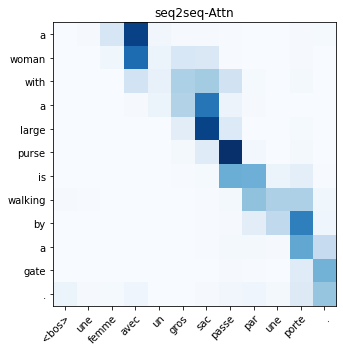

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

weights = np.array(weights)[0:len(trans_language), 0:len(src_language_token_strs)]

fig, ax = plt.subplots(figsize=(15, 5))
im = ax.imshow(weights,cmap=plt.cm.Blues)
# plt.colorbar(im)
# We want to show all ticks...
ax.set_xticks(np.arange(len(src_language_token_strs)))
ax.set_yticks(np.arange(len(trans_language)))
# ... and label them with the respective list entries
ax.set_xticklabels(src_language_token_strs)
ax.set_yticklabels(trans_language)

# Rotate the tick labels and set their alignment.
plt.setp(
    ax.get_xticklabels(), 
    rotation=45, 
    ha="right",
    rotation_mode="anchor"
)

ax.set_title("seq2seq-Attn")
fig.tight_layout()
plt.show()

## 11. Evaluation of the model using BLEU

Finally, we will evaluate the trained model using BLEU-4 metric (the same metric we implemented in the last tutorial). 

In [37]:
def inference(model, trg_vocab, test_iter, attention=False, max_trg_len = 64):
    '''
    Function for translation inference

    Input: 
    model: translation model;
    trg_vocab: Target torchtext Vocab.
    test_iter: iterator object with test data.
    attention: the model returns attention weights or not.
    max_trg_len: the maximal length of translation text (optinal), default = 64

    Output:
    Corpus BLEU score.
    '''
    from nltk.translate.bleu_score import corpus_bleu
    from nltk.translate.bleu_score import sentence_bleu

    # convert index to text string
    def convert_itos(convert_vocab, token_ids):
        list_string = []
        for i in token_ids:
            if i == convert_vocab.get_stoi()['<eos>']:
                break
            else:
                token = convert_vocab.get_itos()[i]
                list_string.append(token)
        return list_string

    model.eval()
    all_trg = []
    all_translated_trg = []
    #all_attention_weights = []

    TRG_PAD_IDX = trg_vocab['<pad>']

    with torch.no_grad():
    
        for i, (src, trg) in enumerate(test_iter):

            src, trg = src.to(device), trg.to(device)

            batch_size = trg.shape[1]

            # create a placeholder for target language with shape of [max_trg_len, batch_size] where all the elements are the index of <pad>. Then send to device
            trg_placeholder = torch.Tensor(max_trg_len, batch_size)
            trg_placeholder.fill_(TRG_PAD_IDX)
            trg_placeholder = trg_placeholder.long().to(device)
            if attention == True:
                output,_ = model(src, trg_placeholder, 0) #turn off teacher forcing
            else:
                #original 
                #output,_ = model(src, trg_placeholder, 0) #turn off teacher forcing
                
                # update:
                output, all_attention_weights = model(src, trg_placeholder, 0) #turn off teacher forcing
            # get translation results, we ignor first token <sos> in both translation and target sentences. 
            # output_translate = [(trg len - 1), batch, output dim] output dim is size of target vocabulary.
            output_translate = output[1:]
            # store gold target sentences to a list 
            all_trg.append(trg[1:].cpu())

            # Choose top 1 word from decoder's output, we get the probability and index of the word
            prob, token_id = output_translate.data.topk(1)
            translation_token_id = token_id.squeeze(2).cpu()

            # store gold target sentences to a list 
            all_translated_trg.append(translation_token_id)
      
    all_gold_text = []
    all_translated_text = []
    for i in range(len(all_trg)): 
        cur_gold = all_trg[i]
        cur_translation = all_translated_trg[i]
        for j in range(cur_gold.shape[1]):
            gold_convered_strings = convert_itos(trg_vocab, cur_gold[:, j])
            trans_convered_strings = convert_itos(trg_vocab, cur_translation[:, j])

            all_gold_text.append(gold_convered_strings)
            all_translated_text.append(trans_convered_strings)
    #weights = [(1.0, 0, 0, 0), (0.5, 0.5, 0, 0), (0.33, 0.33, 0.33, 0), (0.25, 0.25, 0.25, 0.25)]
    corpus_all_gold_text = [[item] for item in all_gold_text]
    corpus_bleu_score = corpus_bleu(corpus_all_gold_text, all_translated_text)  
    return corpus_bleu_score

In [38]:
print(inference(model_best, trg_saved, test_iter, attention=False, max_trg_len=64))

0.3949748774533941


## Reference 
* https://pytorch.org/docs/stable/nn.html
* https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb
* https://arxiv.org/abs/1409.3215
* https://github.com/graviraja/seq2seq
* https://github.com/eladhoffer/seq2seq.pytorch
* https://github.com/spro/practical-pytorch/tree/master/seq2seq-translation
* http://mlexplained.com/2018/02/08/a-comprehensive-tutorial-to-torchtext/
* http://web.stanford.edu/class/cs224n/slides/cs224n-2020-lecture08-nmt.pdf